<img src='https://github.com/LinkedEarth/Logos/raw/master/PYLEOCLIM_logo_HORZ-01.png' width="800">

# Uniform time sampling with Pyleoclim

## Preamble

A common issue in the paleosciences is the presence of uneven time spacing between consecutive observations. While `pyleoclim` includes several methods that can deal with this effectively, there are certain applications for which it is ncessary to place the records on a uniform time axis. In this tutorial you'll learn a few ways to do with `pyleoclim`.

### Goals:

* Become familiar with time regridding methods in Pyleoclim

**Reading Time:**

10 minutes

### Keywords

Signal Processing; Visualization

### Pre-requisites

None. This tutorial assumes basic knowledge of Python. If you are not familiar with this coding language, check out this tutorial: http://linked.earth/ec_workshops_py/.

### Relevant Packages

Matplotlib

## Data Description
EPICA Dome C Deuterium record from [Jouzel et al, 2007](https://doi.org/10.1126/science.1141038)

## Demonstration

Let's import the packages needed for this tutorial:

In [1]:
%load_ext watermark
import pyleoclim as pyleo
import matplotlib.pyplot as plt

The dataset ships with Pyleoclim, so it is very quick to load. However, the original timescale is in years BP, which gets unwieldy after counting throigh 800,000 of them. We thus convert to "ky BP", using intuitive semantics:

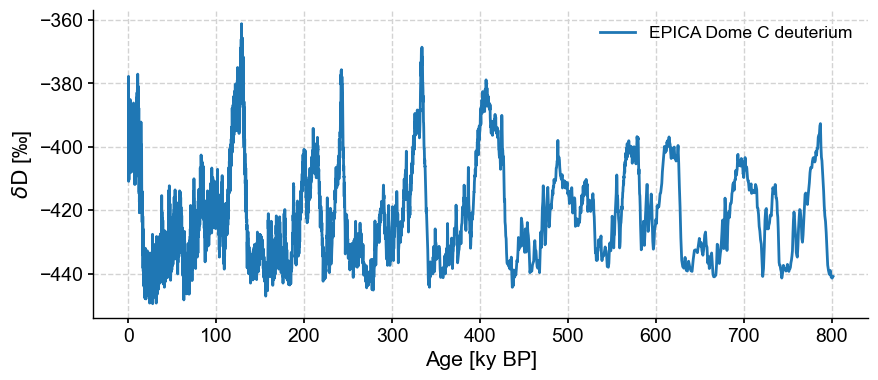

In [2]:
tsy = pyleo.utils.load_dataset('EDC-dD')
ts = tsy.convert_time_unit('ky BP')
fig, ax = ts.plot() 

First we should check whether this is necessary with the `.is_evenly_spaced()` method:

In [3]:
ts.is_evenly_spaced()

False

## An uneven resolution
First we inspect the records' resolution, i.e. the distribution and sequence of its time increments.
TODO: replace with `resolution.dashboard()`

In [4]:
res = ts.resolution()
res.describe()

{'nobs': 5784,
 'minmax': (0.008244210009855486, 1.3640000000207237),
 'mean': 0.13859329637102363,
 'variance': 0.029806736482500852,
 'skewness': 2.6618614618357794,
 'kurtosis': 8.705801510816693}

(<Figure size 1100x800 with 2 Axes>,
 {'res': <Axes: xlabel='Age [ky BP]', ylabel='resolution [ky BP]'>,
  'res_hist': <Axes: xlabel='Counts'>})

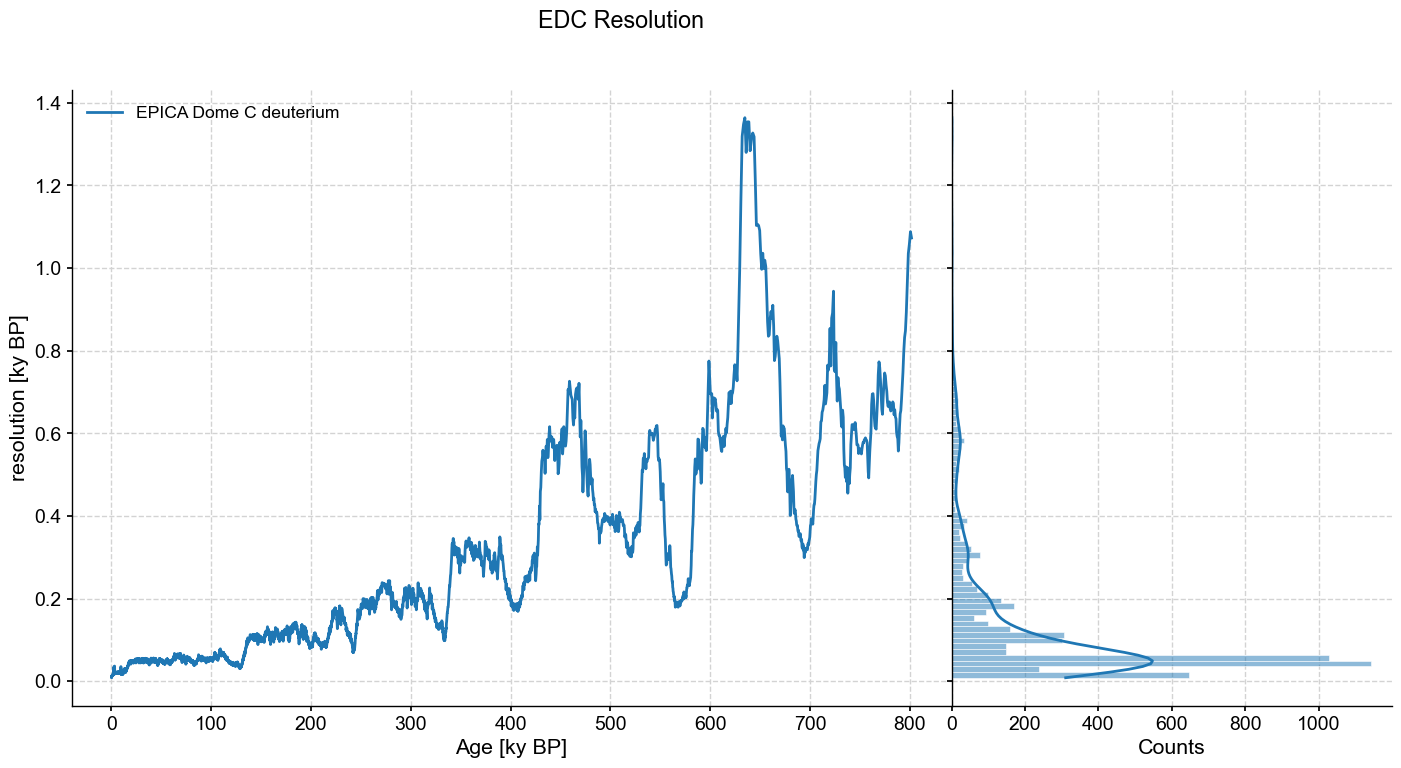

In [5]:
res.dashboard(title='EDC Resolution')

We can see that the series is very unevenly spaced, with a resolution of ~100y at the beginning (top), increasing to over 1000y near the end (bottom) of the core.  There are a variety of reasons why we might want to place these data on an even time grid, usually to apply a technique that requires it to be evenly spaced (most timeseries methods make this assumption). For instance, a [savitzky-golay filter](https://pyleoclim-util.readthedocs.io/en/latest/core/api.html#pyleoclim.core.series.Series.filter)), a detrending method, and so on. 

There are a few different methods available in `Pyleoclim` to place them on a uniform axis: interpolating, binning, resampling and coarse graining via a Gaussian kernel. Let's look at them in sequence. 

### Solution 1: Interpolation

Interpolation projects the data onto an evenly spaced time axis with a distance between points (step size) of our choosing. The default step size is the mean spacing between consecutive points. There are a variety of different methods by which the data can be interpolated, these being: `linear`, `nearest`, `zero`, `slinear`, `quadratic`, `cubic`, `previous`, and `next`. More on these and their associated key word arguments can be found in the [documentation](https://pyleoclim-util.readthedocs.io/en/latest/core/api.html#pyleoclim.core.series.Series.interp). By default, `.interp()` implements linear interpolation:

In [6]:
ts_linear = ts.interp()

Let's check whether or not the series is now evenly spaced:

In [7]:
ts_linear.is_evenly_spaced()

True

Success! Let's take a look at our handiwork.

<Axes: xlabel='Age [ky BP]', ylabel='$\\delta \\mathrm{D}$ [‰]'>

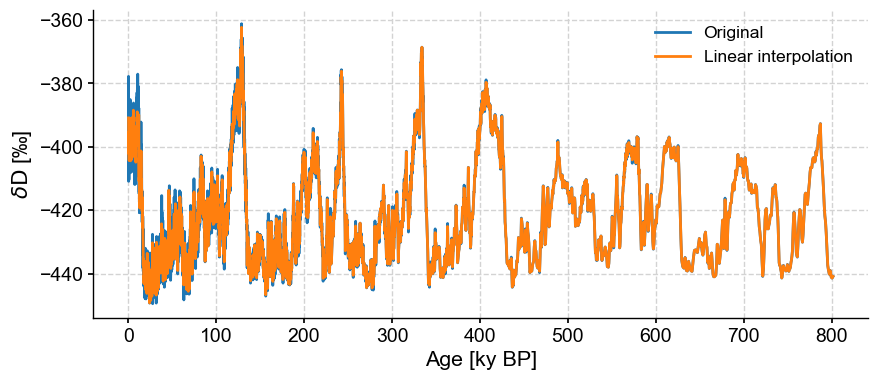

In [8]:
fig, ax = ts.plot(label='Original')
ts_linear.plot(ax=ax,label='Linear interpolation')

If we wanted a coarser resolution, we need only specify the `step` parameter.

In [9]:
ts_linear = ts.interp(step=5) 
ts_linear.label = '5ka linear interpolation'

<Axes: xlabel='Age [ky BP]', ylabel='$\\delta \\mathrm{D}$ [‰]'>

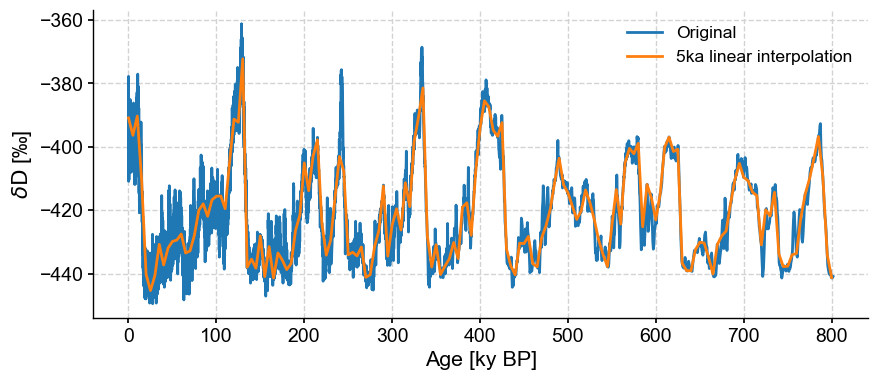

In [10]:
fig, ax = ts.plot(label='Original')
ts_linear.plot(ax=ax)

Linear interpolation is generally safest, because it makes the fewest assumptions. However, for coarse time grids, it can look a little jagged. Let's compare a few of the different methods with one another just to see how they might differ:

In [11]:
ts_quadratic=ts.interp(method='quadratic',step=5)
ts_next = ts.interp(method='next',step=5)
ts_zero = ts.interp(method='zero',step=5)

Text(0.5, 1.0, 'Interpolation 4 ways')

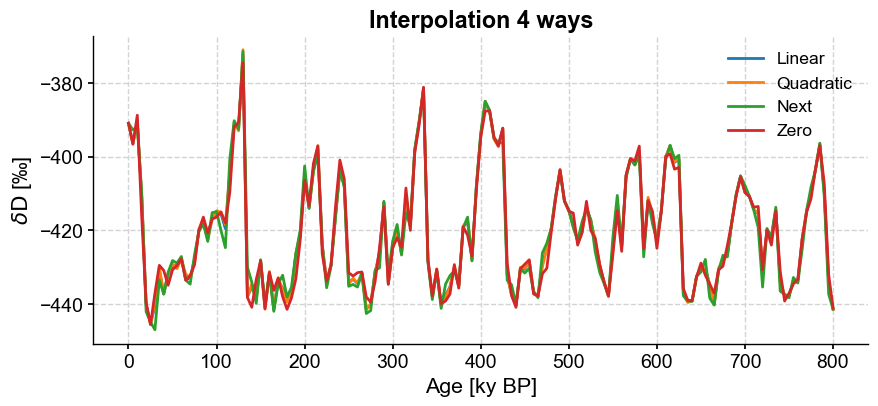

In [12]:
fig,ax = ts_linear.plot(label='Linear')
ts_quadratic.plot(ax=ax,label='Quadratic')
ts_next.plot(ax=ax,label='Next')
ts_zero.plot(ax=ax,label='Zero')
ax.set_title('Interpolation 4 ways',fontweight='bold')

You can see how the methods can produce fairly similar results. If we fiddled more with keyword arguments, the differences would be even more obvious. Play around a bit and read the documentation to find the solution that best suits your needs.

### Solution 2: Binning

Instead of interpolating we could average the series values over uniform bins. The defaults for binning are inherently quite conservative, picking as bin size the coarsest time spacing present in the dataset, and averaging data over a uniform sequence of such intervals: 

In [13]:
ts_bin = ts.bin()
ts_bin.label = 'binning (default)'

<Axes: xlabel='Age [ky BP]', ylabel='$\\delta \\mathrm{D}$ [‰]'>

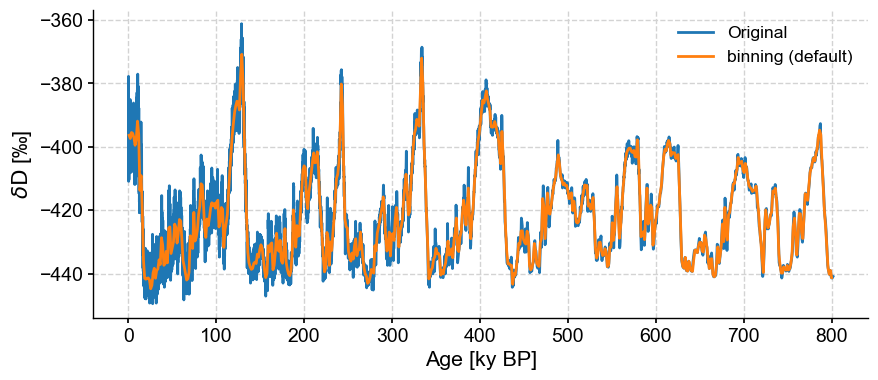

In [14]:
fig, ax = ts.plot(label='Original')
ts_bin.plot(ax=ax)

JEG: this doesn't look conservative at all to me. Are we use it's not using the mean bin size?

If we want this to be less conservative we can set the bin size using the `bin_size` key word argument, but that means the series is no longer guaranteed to be evenly spaced.

In [15]:
ts_bin = ts.bin(bin_size=5)
ts_bin.label='5ka binning'

/var/folders/bf/_x19bm694857h_hrw44j0p7w0000gn/T/ipykernel_60228/652969324.py:1: UserWarning: The step, time axis, or bin edges have been set, the series may not be evenly_spaced
  ts_bin = ts.bin(bin_size=5)


Don't believe the scary message: it is indeed evenly-spaced:

In [16]:
ts_bin.is_evenly_spaced()

True

<Axes: xlabel='Age [ky BP]', ylabel='$\\delta \\mathrm{D}$ [‰]'>

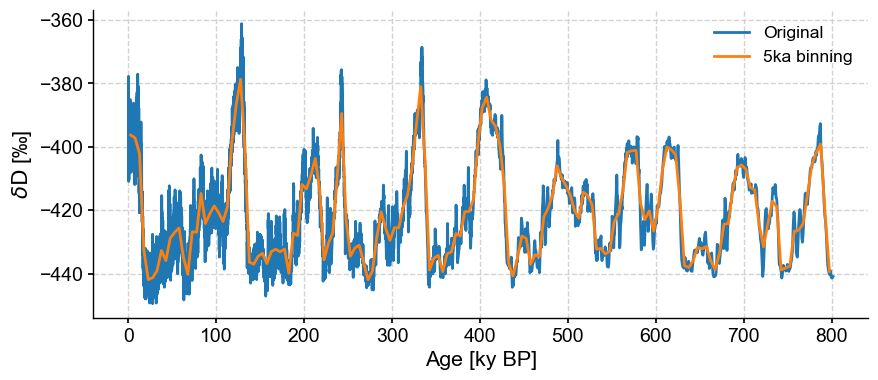

In [17]:
fig,ax = ts.plot(label='Original')
ts_bin.plot(ax=ax)

### Solution 3: Resampling

As introduced in [the pandas demo](./L0_paleopandas.md), another option is to use the pandas [resampler](https://pyleoclim-util.readthedocs.io/en/latest/core/api.html#pyleoclim.core.series.Series.resample), then aggregate the data in some way, e.g. by averaging (though resample offers [many more options](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#resampling), few of which are helpful to a paleoclimatologist). Let's stick with goold old averaging, then:


<Axes: xlabel='Age [ky BP]', ylabel='$\\delta \\mathrm{D}$ [‰]'>

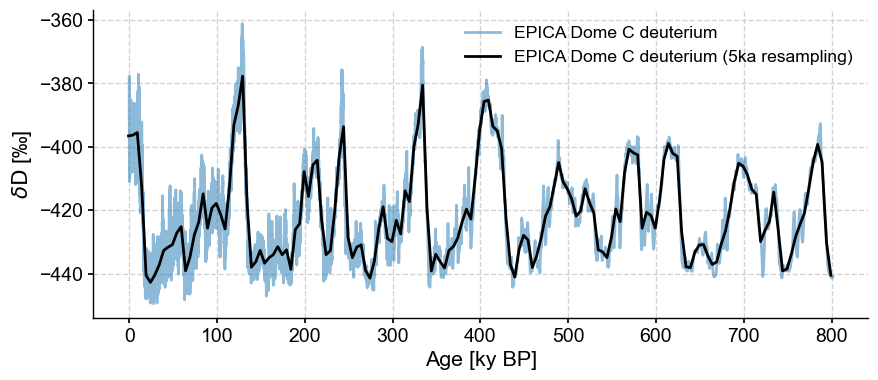

In [18]:
ts5k = ts.resample('5ka').mean()
fig, ax = ts.plot(alpha=.5)
ts5k.plot(ax=ax,color='black')

One nice thing is that `resample` automatically updates the `Series` label for you. It also understand time semantics, so you can specify units, as we've done here. If you think it looks very much like binning, you are not wrong. Let's line them up to better see the effect:

<Axes: xlabel='Age [ky BP]', ylabel='$\\delta \\mathrm{D}$ [‰]'>

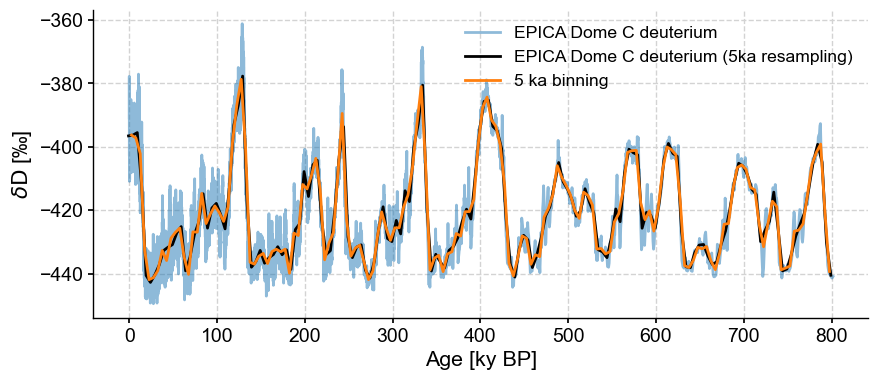

In [19]:
fig, ax = ts.plot(alpha=.5)
ts5k.plot(ax=ax,color='black')
ts_bin.plot(ax=ax,label='5 ka binning')

Indeed, they are very close.  

### Solution 4: Coarsening with a Gaussian kernel

The last option is to coarsen the series using a Gaussian kernel ([Rehfeld et al. (2011)](https://doi.org/10.5194/npg-18-389-2011)) via the `.gkernel()` method. Like `.bin()` this technique is conservative and uses the max space between points as the default spacing. Unlike `.bin()`, `.gkernel()` uses a Gaussian kernel to calculate the weighted average of the time series over these intervals.

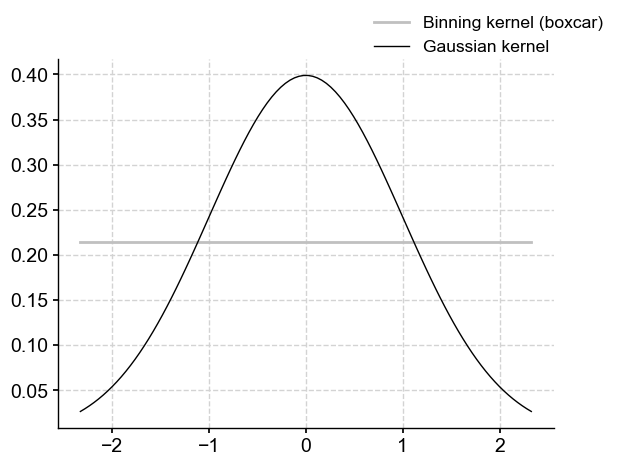

In [20]:
from scipy.stats import norm
import numpy as np
rv = norm()
x = np.linspace(norm.ppf(0.01), norm.ppf(0.99), 100)
unif = np.ones_like(x)/np.ptp(x)
fig, ax = plt.subplots()
ax.plot(x, unif, color='silver',label='Binning kernel (boxcar)')
ax.plot(x, rv.pdf(x), 'k-', lw=1, label='Gaussian kernel')
fig.legend()

Compared with binning's boxcar, this offers the possibility of centering the average on each observation, dropping off smoothly away (as opposed to brutally dropping off to 0 at the bin's edge). Let's see it in action:

<Axes: xlabel='Age [ky BP]', ylabel='$\\delta \\mathrm{D}$ [‰]'>

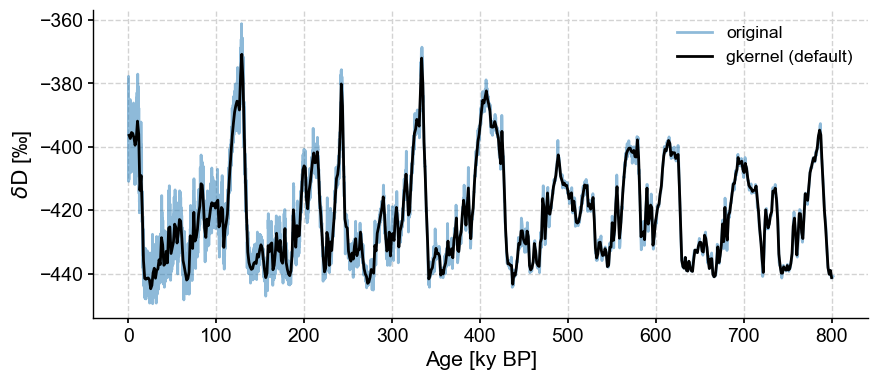

In [21]:
ts_gk = ts.gkernel()
fig,ax = ts.plot(label='original', alpha=.5)
ts_gk.plot(ax=ax,label='gkernel (default)',color='black')

Though the default uses the maximum bin size, the result is relatively smooth. If one gets greedy and grabs the mean step size (here, ~138y), bad surprises await:

<Axes: xlabel='Age [ky BP]', ylabel='$\\delta \\mathrm{D}$ [‰]'>

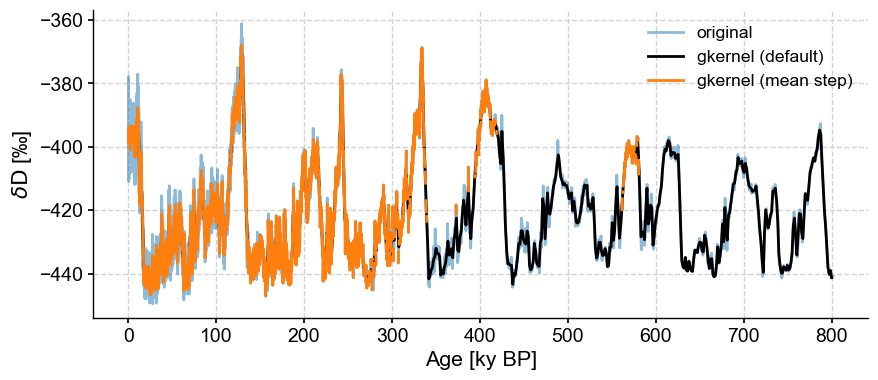

In [22]:
fig,ax = ts.plot(label='original', alpha=.5)
ts_gk.plot(ax=ax,label='gkernel (default)',color='black')
ts.gkernel(step_style='mean').plot(label='gkernel (mean step)',color='C1',ax=ax)

What is happening here is that we're asking the method to make up data where it cannot find any (bins smaller than the actual spacing between points), so it protests silently by outputting NaNs over those intervals. In a plot like this, NaNs are invisible, hence the relative absence of orange ink prior to 400 ky BP on the plot above. 

`gkernel` has another parameter: the kernel bandwidth $h$, which governs the width of the Gaussian used for the averaging. The default value is 3, and it typically has a weak influence over the result. For instance:

<Axes: xlabel='Age [ky BP]', ylabel='$\\delta \\mathrm{D}$ [‰]'>

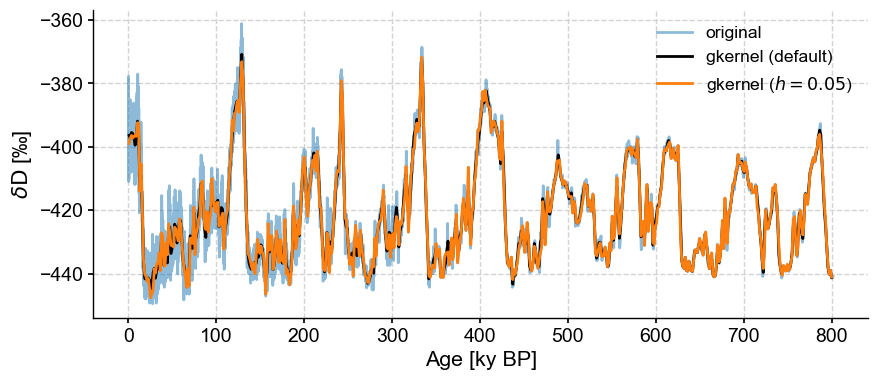

In [23]:
fig,ax = ts.plot(label='original', alpha=.5)
ts_gk.plot(ax=ax,label='gkernel (default)',color='black')
ts.gkernel(h=.05).plot(label='gkernel ($h=0.05$)',color='C1',ax=ax)

Insisting on a an overly narrow kernel will also result in bins with no values:

/Users/julieneg/Documents/GitHub/Pyleoclim_util/pyleoclim/utils/tsutils.py:477: RuntimeWarning: invalid value encountered in double_scalars
  yc[i]  = sum(weight*yslice)/sum(weight) # normalize by the sum of weights


<Axes: xlabel='Age [ky BP]', ylabel='$\\delta \\mathrm{D}$ [‰]'>

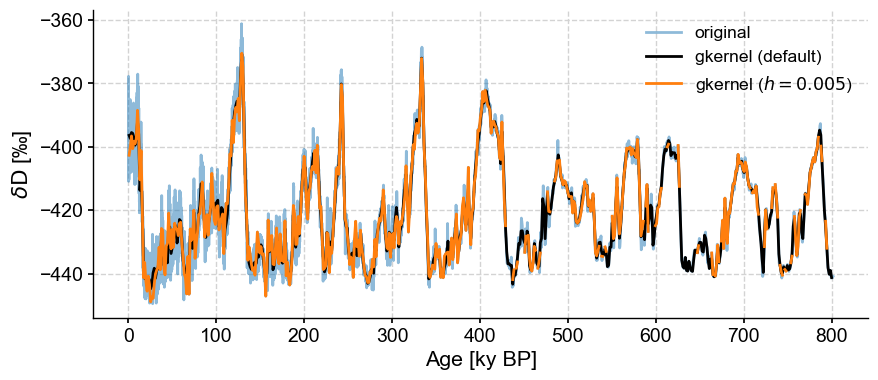

In [24]:
fig,ax = ts.plot(label='original', alpha=.5)
ts_gk.plot(ax=ax,label='gkernel (default)',color='black')
ts.gkernel(h=.005).plot(label='gkernel ($h=0.005$)',color='C1',ax=ax)

## Battle Royale

Let's now look at how these methods compare to place the data on an even 5ka grid:

/var/folders/bf/_x19bm694857h_hrw44j0p7w0000gn/T/ipykernel_60228/2012472177.py:5: UserWarning: The step or bins has been set, the series may not be evenly_spaced
  ts.gkernel(step=5).plot(ax=ax, label='5ka gkernel')


<Axes: xlabel='Age [ky BP]', ylabel='$\\delta \\mathrm{D}$ [‰]'>

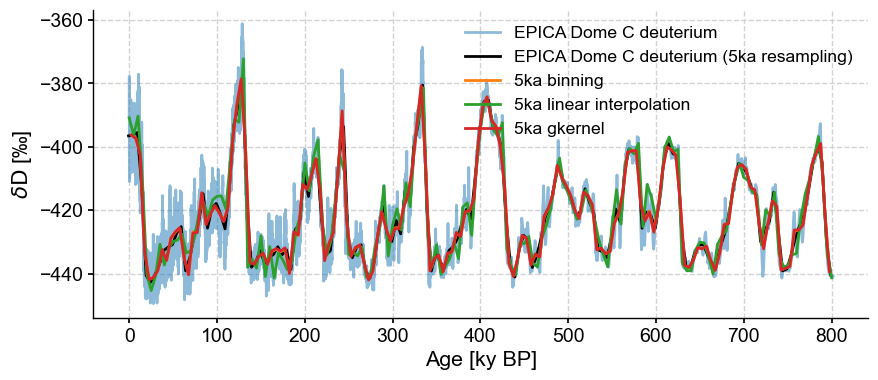

In [25]:
fig, ax = ts.plot(alpha=.5)
ts5k.plot(ax=ax,color='black')
ts_bin.plot(ax=ax)
ts_linear.plot(ax=ax)
ts.gkernel(step=5).plot(ax=ax, label='5ka gkernel') 

The results are quite similar. One can see that `gkernel` is a tad smoother than the lot, `interp` more jerky than the lot. 

## Summary
As of version 0.11.0, `pyleoclim` features no fewer than 4 methods to place a timeseries on a uniform time axis. Each of these methods has its own keyword arguments that can be adjusted to produce different results. A comprehensive investigation of these arguments and how they affect the outcome of the imputation is left as an exercise for the reader. In general, we recommend trying several strategies to check that your analysis is not overly sensitive to any particular choice of method/parameter.

Equally important is to know when **not** to apply these methods: for [spectral](L2_spectral_analysis.md) and [wavelet](L2_wavelet_analysis.md) analysis, `pyleoclim` implements methods that do not require evenly-spaced data. In those cases, one can happily abstain from regridding. In all other cases, however, you should feel free to regrid with abandon, but always be mindful of robustness.

In [26]:
%watermark -n -u -v -iv -w

Last updated: Thu Apr 20 2023

Python implementation: CPython
Python version       : 3.10.10
IPython version      : 8.12.0

matplotlib: 3.7.1
numpy     : 1.23.5
pyleoclim : 0.11.0

Watermark: 2.3.1

